# Validación Cruzada, Curvas de Validación y Curvas de ROC

¡Gracias Martín Gonella por la creación de los contenidos de este encuentro!


En este notebook veremos cómo utilizar Validación Cruzada en Scikit-Learn. Luego, veremos cómo hacer una curva de validación incorporando esta técnica. Finalmente, haremos una curva ROC.


## 1. Validación Cruzada

En esta sección entrenaremos un modelo de árboles de decisión y uno de vecinos más cercanos sobre un nuevo dataset. Luego, evaluaremos estos modelos usando Validación Cruzada. 

### 1.1 Carga de Datos

Scikit-Learn provee varias funciones para cargar datasets y también para generar datasets. Hoy vamos a usar el Breast Cancer Wisconsin (diagnostic) dataset. Empezaremos cargando los datos y haciendo una pequeña exploración.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [96]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

Si observan la variable `data`, podrán notar que es un `diccionario`, por lo tanto vamos a proceder a convertirlo en un `DataFrame` de Pandas.

In [97]:
df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [98]:

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


¡Ya tenemos nuestro dataset en un DataFrame de Pandas!

Comencemos con un poco de exploración.

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Ahora veamos cuantos datos de cada etiqueta tenemos, para ellos debemos ver la columna `target`.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


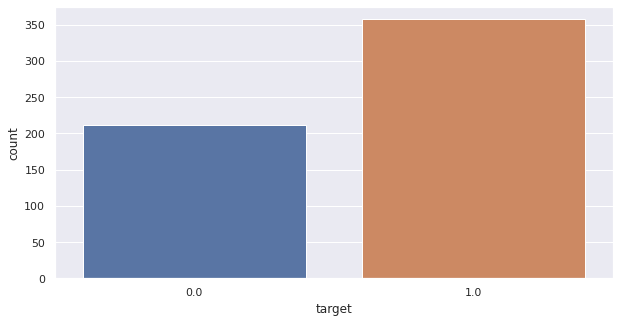

In [100]:
plt.figure(figsize=(10,5))
sns.countplot(df['target'],label="Count")
plt.show()

#el dataset esta levemente desbalanceado . Siempre es bueno chequear el balance del dataset (del target en general)
#1 es cancer 0 es no cancer.

#veo la proporcion de datos con cancer  que no cancer es como un 60/40 no estaría Tan desbalanciados

Para facilitar el análisis, seleccionamos solo aquellas columnas donde los nombres de los atributos comiencen con la palabra `mean`.

In [101]:
features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [102]:
df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


**Ejercicio:** Ahora que ya filtramos las columnas con las cuales vamos a trabajar, crea un `pairplot()` y grafica una matriz de correlaciones. 

¿Cuáles atributos están correlacionados?

    mean perimeter
    mean area
    mean radius
    mean concave points
    mean texture
    mean smoothnees

¿Se te ocurre por qué?
Las propiedades geométricas tienen una relación directa entre sí y tienden a separar mejor los datos y las distribuciones.
También las propiedades de textura se relaciónan con la forma de las mamas femeninas.
En terminos medios son distribuciones que no presentan datos muy atípicos.

In [103]:
def Correlation_fig(X):
    """
    Genera un heatmap con una estructura especifica para mi set de datos.
    """
    sns.set(style="whitegrid")
    corr = X.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(8,8))
    sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,vmin=0, cbar=True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12})
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    plt.title('Correlación de Atributos')
    plt.show()






sns.pairplot(df,hue='target')

Correlation_fig(df)



Output hidden; open in https://colab.research.google.com to view.

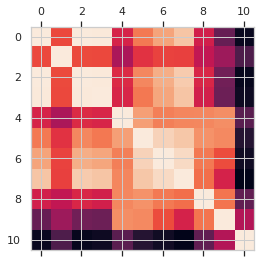

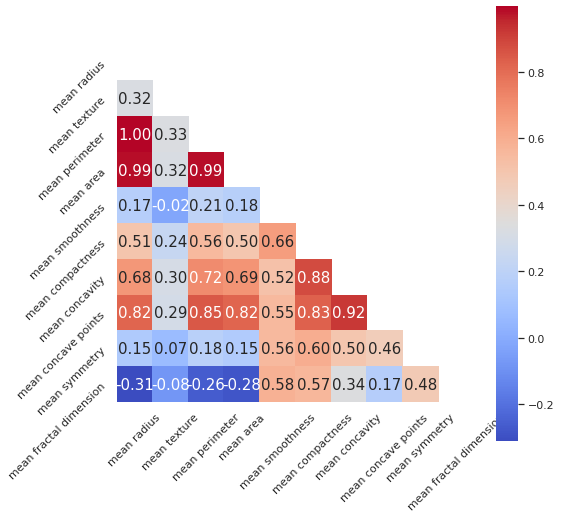

In [104]:
plt.matshow(df.corr())
#buscar 
#https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.matshow.html

corr = df.drop(columns = 'target').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,mask=mask , square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.drop(columns = 'target').columns, 
           yticklabels= df.drop(columns = 'target').columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

### 1.2 Entrenamiento de los modelos

Vamos a entrenar un árbol de decisión de profundidad infinita (`max_depth = None`) y un modelo de vecinos más cercanos con `n_neighbors=1`. Los vamos a entrenar y evaluar haciendo un `train_test_split` (con `test_size=0.10`) de los datos. Pero antes de eso, debemos seleccionar las variables de entrenamiento y la etiqueta.

In [105]:
# X = df.drop(columns = ['target'])
X = df[['mean radius','mean smoothness', 'mean concave points']] #Observa que sólo usamos 3 features del dataset
y = df['target']


Como ya hemos visto anteriormente, debemos proceder a reescalar los datos.

In [106]:
from sklearn.preprocessing import StandardScaler  #como tengo un knn primero escalo los datos!!!

scl = StandardScaler()  #estandariza a una misma unidad de medida de todas las variables continuas. es como el zscores
X = scl.fit_transform(X)

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

#***Tip:*** Una buena práctica cuando separamos en conjuntos de `train` y `test` es chequear que las distribuciones que obtenemos sean similares. Obviamente, a medida que tenemos más features, esto se hace más difícil.

In [108]:
X_train.shape[1] #me da las columnas de mis atributos. es decir son los datos de cada atributo
#veo la distribucion de los datos para cada atributo

3

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


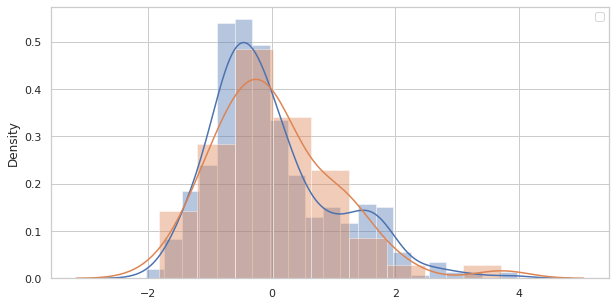

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


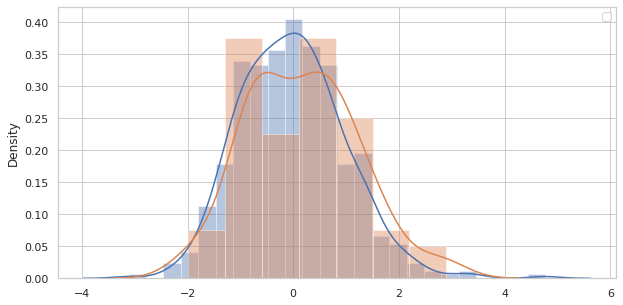

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


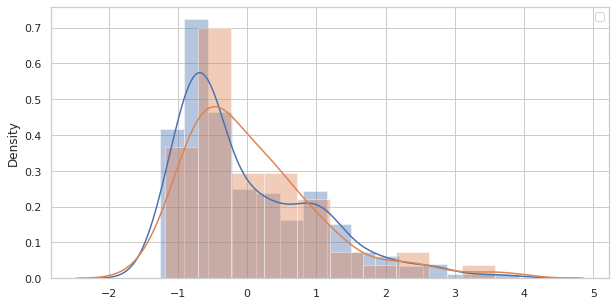

In [109]:
for i in range(X_train.shape[1]):
    plt.figure(figsize=(10,5))
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.legend()
    plt.show()

#muestra la distribucion de los datos de entrenamiento y prueba (para ver si son muy distintas o no)
#si la distribución es distinta, es porque la separacion de los datos es distinta y puede sesgar el modelo o la performance.

Pero... ¿Será suficiente chequear esto?

##***Tip 2:*** Otras cosa que podemos hacer es chequear que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida.

In [110]:
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

#con la division de los datos, suplimos la division de los datos

Proporcion de etiquetas positiva en los datos de Train:  0.630859375
Proporcion de etiquetas positiva en los datos de Test:  0.5964912280701754


**Para pensar:** Y si la proporcición no fuera parecida, ¿Qué deberíamos hacer? 

Modificar la semilla random_state hasta encontrar un balance entre ambos.

**Ejercicio:** ¿Qué hace el parámetro `stratify` de la función `train_test_split()`?

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/

Stratified Train-Test Splits

One final consideration is for classification problems only.

Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

This is called a stratified train-test split.

We can achieve this by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array


**Para pensar**: ¿Cuál será desempeño aproximado - accuracy - del modelo más sencillo que podemos crear para detectar casos positivos? -> benchmarks.

como el target es binario y los atributos presentan una alta correlación es esperable que el accuracy sea alto para un modelo sencillo.

#### A entrenar...

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#### `Árbol de Decisión`

In [112]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [113]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

#puede ser que este sobreentrenado (habria que validarlo con otro modelo)

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.9122807017543859


#### `KNN`

In [114]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [115]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8771929824561403


Bien, cada modelo obtuvo un determinado desempeño... Pero, ¿Este desempeño depende de la partición que hayamos hecho de los datos de `train/test`?

**Ejercicio:** Para ver si esto es cierto, vuelve a realizar la partición de datos pero ésta vez modifiquen el argumento `random_state` de la función `train_test_split()`. ¿Obtienes los mismos resultados?

La idea es si yo hubiese hecho otra separación obtengo la misma metrica o no? .. es decir con el random state la semilla cambio el reordenamiento de los datos.

In [116]:


#al modificar el random_state del traintestsplit, modificaría la partición de los datos (lo inicio con un valor y hago una particion de los datos).
#pero en teoria no cambian mucho las metricas


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

#### `Árbol de Decisión`

In [117]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [118]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8859649122807017


#### `KNN`

In [119]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [120]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8859649122807017


Si estratifico mis variables y la metrica mejora con los datos de validación.

modificando la partición de los datos test/train y modificando el random state tiende a desmejorar el desempeño de la metrica.

### 1.3 Validación Cruzada

Vamos a evaluar los modelos que creamos utilizando validación cruzada.

Scikit-Learn tiene varias funciones ya incorporadas que evalúan los modelos usando validación cruzada. Las más sencilla de usar es `cross_val_score()`, que evalúa un score (para clasificaciones por defecto es el `Accuracy`) y de un modelo por CV.

In [121]:
from sklearn.model_selection import cross_val_score
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

#cv   int, cross-validation generator or an iterable, default=None
#    Determines the cross-validation splitting strategy. Possible inputs for cv are:
 #       None, to use the default 5-fold cross validation
 #       int, to specify the number of folds in a (Stratified)KFold,        CV splitter,
#        An iterable yielding (train, test) splits as arrays of indices.
#    For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

In [122]:
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)#-->calcula 5 modelos
#tomame un modelo, con estos datos y haceme la cross validation en funcion de los kfold que le digo
#ej cv=10 la division de los datos es 10 test y 90 train (con 100 datos)
#ej con cv=2 50 test y 50 train

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)   #default metrica del cv es accuracy

#el cross validation lo que hace es tomar a mis datos y generar cv cantidad de plieges o cortes de muestra y calcula el accuracy en este caso 

In [123]:
print(tree_scores, knn_scores)
# print(tree_scores.mean(), knn_scores.mean())
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

#el desvio me dice hacia la derecha o izuqierda como estan distribuidos los resultados que obtuve
#si el desvio es más grande, los modelos tienden a ser distintos respecto a que datos tomo (la diferencia de los modelos no radica en el modelo perse (mismo hiperparametro), sino que  varian los datos)


[0.86842105 0.89473684 0.9122807  0.92982456 0.88495575] [0.87719298 0.88596491 0.87719298 0.92105263 0.89380531]
Accuracy para Tree: 0.90 (+/- 0.04)
Accuracy para KNN: 0.89 (+/- 0.03)


##**¡Ahora podemos obtener una evaluación del modelo que no depende tanto de la partición hecha!**

Por otra parte, `cross_validate()` es otra función muy parecida, pero un poco más versátil e informativa. Además de devolver los `scores`, devuelve algunas métricas que pueden ser útiles, como por ejemplo: tiempo de entrenamiento, los modelos entrenados, etc. Además, permite evaluar más de una métrica.

In [124]:
from sklearn.model_selection import cross_validate
#funcipon "más versatil", devuelve otras metricas últiles
#como tiempo de entrenamiento, tiempo de calcular la metrica y datos de los scores

In [125]:
tree_scores = cross_validate(tree, X, y, cv=5)
knn_scores = cross_validate(knn, X, y, cv=5)

In [126]:
print(tree_scores)
print(knn_scores)

{'fit_time': array([0.00237799, 0.00231171, 0.00230861, 0.00241613, 0.00261688]), 'score_time': array([0.00090075, 0.0007565 , 0.00070763, 0.00122595, 0.00081849]), 'test_score': array([0.85087719, 0.87719298, 0.9122807 , 0.93859649, 0.88495575])}
{'fit_time': array([0.00093722, 0.00091505, 0.00098777, 0.00092626, 0.00086451]), 'score_time': array([0.00431395, 0.00398493, 0.00391579, 0.00382805, 0.00372696]), 'test_score': array([0.87719298, 0.88596491, 0.87719298, 0.92105263, 0.89380531])}


La siguiente celda imprime una lista de todas las métricas que podemos usar para evaluar con `cross_validate()`

In [127]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys()) #tipo de scores en sklearn

#tipos de metricas para hacer el cross validation

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

**Ejercicio - Challenge:** Como habrás notado antes de entrenar los modelos, volvímos a filtrar el dataset y sólo usamos tres features del mismo:

```python
X = df[['mean radius','mean smoothness', 'mean concave points']]
```

Vuelve a entrenar los modelos, pero con otras features. Puedes ver la matriz de correlaciones si deseas y en base a lo que ves allí realizar tu elección.

In [128]:
#escuchar clase, probar con una variable cada modelo, o todas las columnas y voy quitando columnas. y evaluo los desempeños para elegir el mejor atributo
#libro molnar "permutation_importance" es util
#ó se itera este proceso hasta el cross validation para ver la importancia de las variables(atributos) segun el rendimiento de scores


# X = df.drop(columns = ['target'])


X = df[['mean radius','mean perimeter', 'mean area','mean concave points','mean texture','mean smoothness']] #Observa que sólo usamos 3 features del dataset
y = df['target']

In [129]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X = scl.fit_transform(X)

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


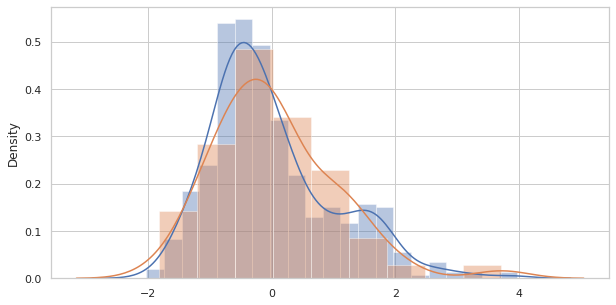

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


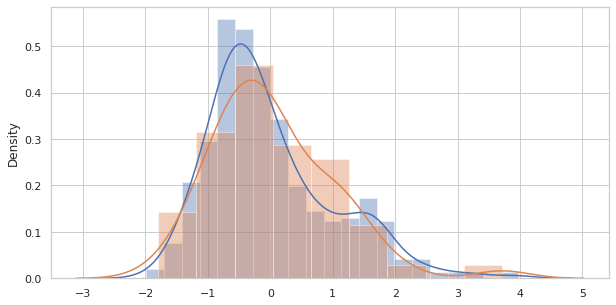

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


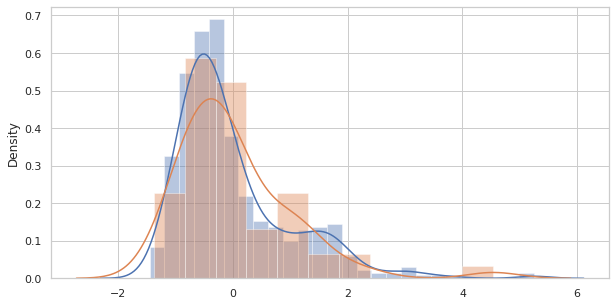

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


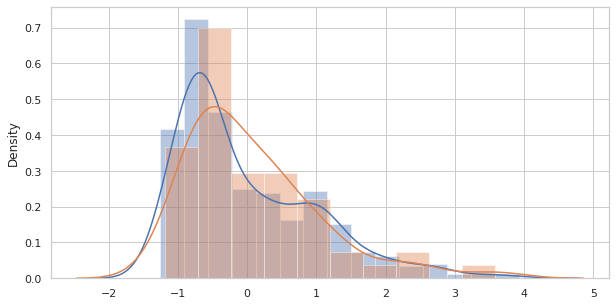

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


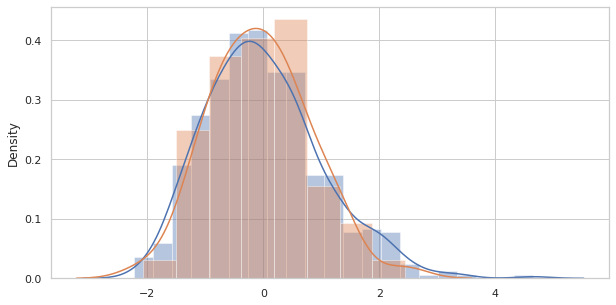

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


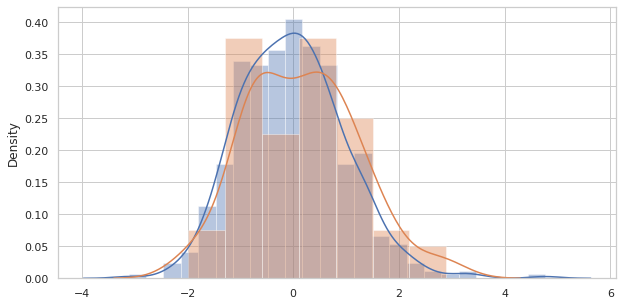

In [131]:
#veo cuan balanceado estan los datos
for i in range(X_train.shape[1]):
    plt.figure(figsize=(10,5))
    sns.distplot(X_train[:,i])
    sns.distplot(X_test[:,i])
    plt.show()

In [132]:
#chequear que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida.
print('Proporcion de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de etiquetas positiva en los datos de Train:  0.630859375
Proporcion de etiquetas positiva en los datos de Test:  0.5964912280701754


#### A entrenar...

In [133]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#### `Árbol de Decisión`

In [134]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [135]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


#### `KNN`

In [136]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [137]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.9473684210526315


Bien, cada modelo obtuvo un determinado desempeño... Pero, ¿Este desempeño depende de la partición que hayamos hecho de los datos de `train/test`?

**Ejercicio:** Para ver si esto es cierto, vuelve a realizar la partición de datos pero ésta vez modifiquen el argumento `random_state` de la función `train_test_split()`. ¿Obtienes los mismos resultados?

In [138]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

#### `Árbol de Decisión`

In [139]:
tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [140]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


#### `KNN`

In [141]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [142]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = knn.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.9210526315789473


### 1.3 Validación Cruzada

Vamos a evaluar los modelos que creamos utilizando validación cruzada.

Scikit-Learn tiene varias funciones ya incorporadas que evalúan los modelos usando validación cruzada. Las más sencilla de usar es `cross_val_score()`, que evalúa un score (para clasificaciones por defecto es el `Accuracy`) y de un modelo por CV.

In [143]:
from sklearn.model_selection import cross_val_score

In [144]:
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)

#el cross validation lo que hace es tomar a mis datos y generar cv cantidad de plieges o cortes de muestra y calcula el accuracy en este caso 

In [145]:
print(tree_scores, knn_scores)
# print(tree_scores.mean(), knn_scores.mean())
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

[0.88596491 0.92105263 0.89473684 0.93859649 0.94690265] [0.90350877 0.88596491 0.93859649 0.9122807  0.92920354]
Accuracy para Tree: 0.92 (+/- 0.05)
Accuracy para KNN: 0.91 (+/- 0.04)


## 2. Curvas de Validación

Ya vimos la importancia de las curvas de validación, ahora veamos como graficar una curva de validación usando los conjuntos de `train` y de `test` que ya creamos y combinando con Validación Cruzada.

In [168]:
scores_train = []
scores_test = []
profundidades = np.arange(1,50)
for max_depth in profundidades:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    scores_train.append(accuracy_score(y_train, y_pred_train))
    scores_test.append(accuracy_score(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

ValueError: ignored

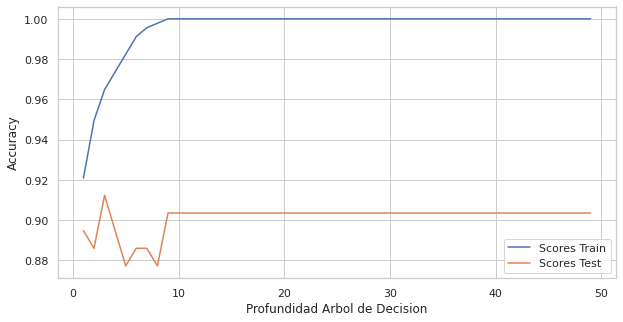

In [147]:
plt.figure(figsize=(10,5))
plt.plot(profundidades,scores_train, label = 'Scores Train')
plt.plot(profundidades,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

¡Pero lo ideal sería graficar la curva de validación aplicando validación cruzada!

###**Es decir una grafica que me muestre los posibles valores del score para un hiperparametro dado (tanto en datos de entrenamiento como validacion)**

In [148]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,50,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1) 
    #return_train_score=devolveme el score en train, por default devuelve solo en test. para hacer curvas de validacion.
    #el tree_scores tendra atributo el train_score, test_score
    #el job=-1 no corre en fila los modelos sino todos juntos, en paralelo. paraleliza
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

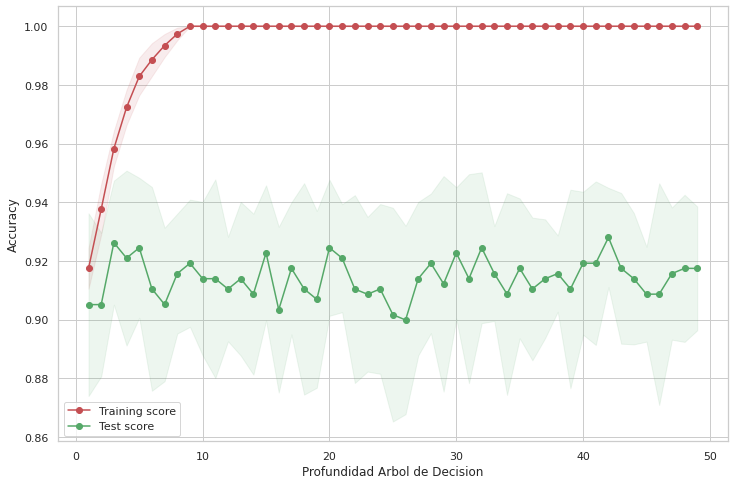

In [149]:
plt.figure(figsize=(12,8))
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

**Ejercicio:** Hacer una curva de validación para un modelo de KNN en función de la cantidad de vecinos, usando además validación cruzada.

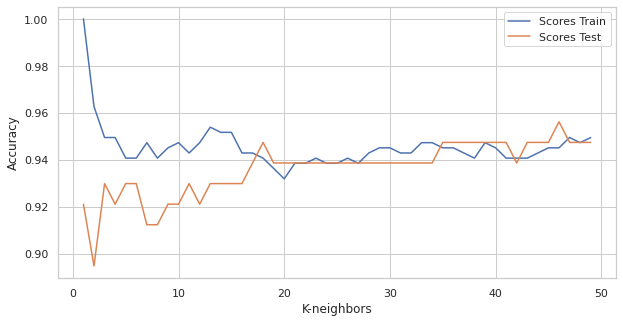

In [150]:
scores_train = []
scores_test = []
vecinos = np.arange(1,50)

for n_neighbors in vecinos:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    
    scores_train.append(accuracy_score(y_train, y_pred_train))
    scores_test.append(accuracy_score(y_test, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)


plt.figure(figsize=(10,5))
plt.plot(profundidades,scores_train, label = 'Scores Train')
plt.plot(profundidades,scores_test, label = 'Scores Test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('K-neighbors')
plt.show()

In [151]:
#Validación cruzada
#Validación cruzada
knn_train_scores_mean = []
knn_train_scores_std = []
knn_test_scores_mean = []
knn_test_scores_std = []

vecinos = np.arange(1,50,1)

for n_neighbors in vecinos:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_scores = cross_validate(knn, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    knn_train_scores_mean.append(knn_scores['train_score'].mean())
    knn_train_scores_std.append(knn_scores['train_score'].std())
    
    knn_test_scores_mean.append(knn_scores['test_score'].mean())
    knn_test_scores_std.append(knn_scores['test_score'].std())

knn_train_scores_mean = np.array(knn_train_scores_mean)
knn_train_scores_std = np.array(knn_train_scores_std)
knn_test_scores_mean = np.array(knn_test_scores_mean)
knn_test_scores_std = np.array(knn_test_scores_std)

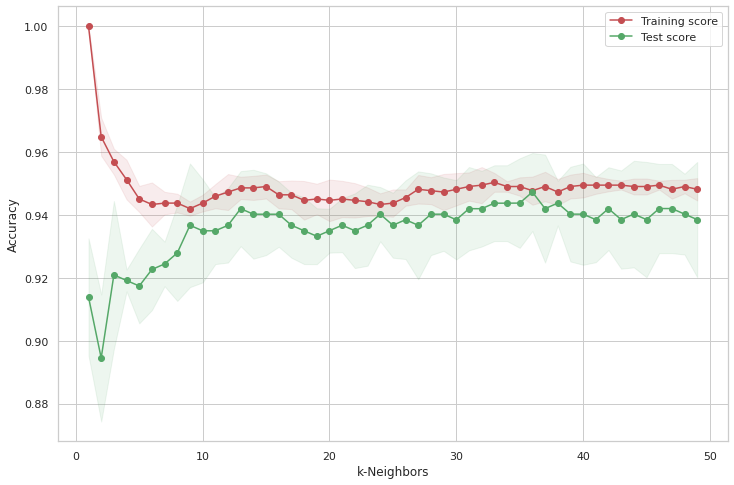

In [152]:
plt.figure(figsize=(12,8))
plt.fill_between(vecinos, knn_train_scores_mean - knn_train_scores_std,
                 knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                 color="r") #hacen las sombras, mas menos un valor, le tengo que poner primero la resta y luego la suma
plt.fill_between(vecinos, knn_test_scores_mean - knn_test_scores_std,
                 knn_test_scores_mean + knn_test_scores_std, alpha=0.1, color="g")
plt.plot(vecinos, knn_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(vecinos, knn_test_scores_mean, 'o-', color="g",
         label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('k-Neighbors')
plt.show()

## 3. Curva de ROC en Scikit-Learn

En primer lugar, dejamos el link a la Documentación de [Curvas de ROC en Scikit-Learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

Indica hacia qué tipo de error prepondera más en el modelo, las falsas alarmas (falso positivo) ó sorpresas (falso negativo)

In [153]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importamos las librerías necesarias para graficar las curva de ROC y calcular el AUC.

In [184]:
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

In [185]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Binarizamos `y_test`

In [187]:
y_test = label_binarize(y_test, classes=[0, 1, 2])  #label encoder
n_classes = y_test.shape[1]
print(y_test[:5])
print(n_classes)

[[0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]
3


In [179]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test) #nos da la probabilidad de una variable frente a las otras.
print(y_score[:5]) #la primera instancia me la pronostica para las 3 variables etiquetas. 
#aca es más facil predecir 80% la categoria 1 para una instancia.

[[0.  0.8 0.2]
 [1.  0.  0. ]
 [0.  0.  1. ]
 [0.  0.8 0.2]
 [0.  0.9 0.1]]


Para tener en cuenta:

* `.predict()` dará como salida un 0 o un 1.
* `.predict_proba()` dará como salida una estimación de la probabilidad.

In [183]:
#todo esto lo hace sklearn solo
# Computamos los valores de FPR y TPR, para poder luego realizar el gráfico de la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

#aca hay un problema de más de dos clases. la curva roc supone que una de las clases es positiva y las demas es negativa (es decir una clase del target vs las demas)


for i in range(n_classes):
    fpr[i], tpr[i], _= roc_curve(y_test[:, i], y_score[:, i])
    #fpr[i], tpr[i],thresholds = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#define los umbrales en funcion del numero de clases
#print(thresholds)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

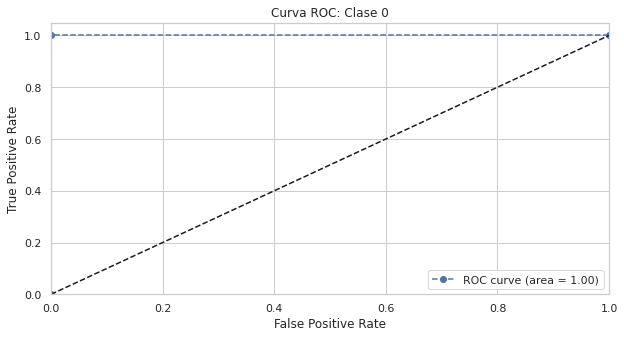

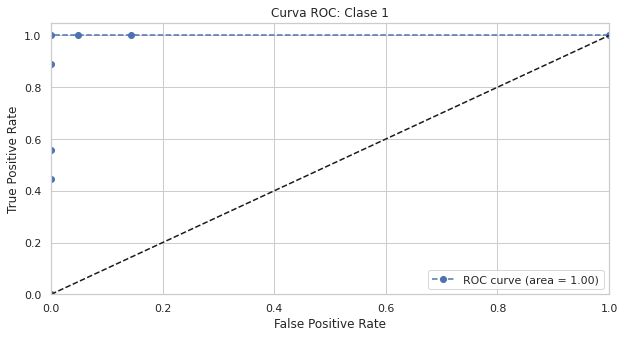

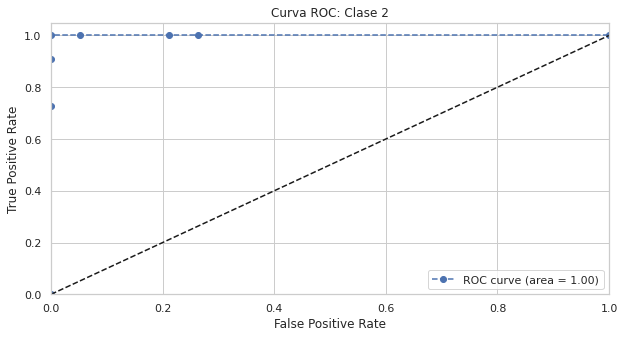

In [182]:
for i in range(n_classes):
    plt.figure(figsize=(10,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.show()
  
  #faltaría que muestre en cada punto el valor del umbral


**Ejercicio:** Buscá algún dataset de clasificación binario (por ejemplo: como el de la primera parte de este notebook), entrena un modelo a tu elección y grafica sus curvas de ROC.

[[0.28571429 0.71428571]
 [1.         0.        ]
 [0.85714286 0.14285714]
 [0.         1.        ]
 [0.         1.        ]]
[[1]
 [0]
 [0]
 [1]
 [1]]


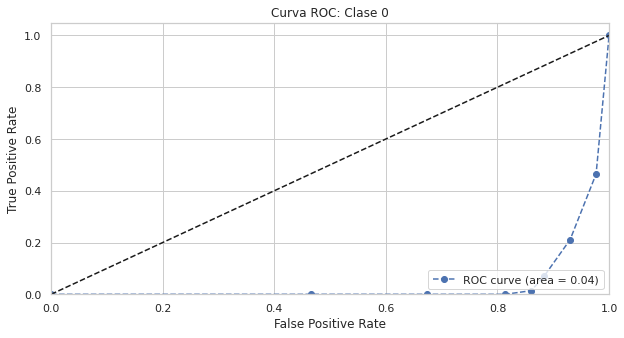

In [163]:
#probar sklearn curvaroc

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))
# X = df.drop(columns = ['target'])
X = df[['mean radius','mean perimeter', 'mean area','mean concave points']] #Observa que sólo usamos 3 features del dataset
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)
print(y_score[:5])



y_test = label_binarize(y_test, classes=[0, 1])
n_classes = y_test.shape[1]
print(y_test[:5])

# Computamos los valores de FPR y TPR, para poder luego realizar el gráfico de la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure(figsize=(10,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.show()